In [72]:
import pickle


pickled_model = pickle.load(open('finalized_model_acc_90.pkl', 'rb'))


In [73]:
image_class = "class2"
image_name= "f6cfecc532a2"
testFilePath = f"./trainFiles/{image_name}.tif"
png_path = f"./output/{image_class}/{image_name}.png"
data = "polygons.jsonl"

In [74]:
# check if the image is in the dataframe
if image_name in polygons_df['id'].values:
    print(f'{image_name} is inside polygons.jsonl')
else:
    print(f'{image_name} is not inside polygons.jsonl')

f6cfecc532a2 is inside polygons.jsonl


In [75]:
import pandas as pd

jsonObj = pd.read_json('./polygons.jsonl', lines=True)
# convert the json object to a dataframe
polygons_df = pd.DataFrame(jsonObj)
polygons_df.head()


,id,annotations
0,0006ff2aa7cd,"[{'type': 'glomerulus', 'coordinates': [[[167,..."
1,00168d1b7522,"[{'type': 'glomerulus', 'coordinates': [[[511,..."
2,0033bbc76b6b,"[{'type': 'blood_vessel', 'coordinates': [[[16..."
3,003504460b3a,"[{'type': 'blood_vessel', 'coordinates': [[[40..."
4,004daf1cbe75,"[{'type': 'blood_vessel', 'coordinates': [[[14..."


In [76]:
import os
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img


def create_mask(polygons, image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for polygon in polygons:
        if polygon['type'] == 'blood_vessel':
            coordinates = np.array(polygon['coordinates'])
            cv2.fillPoly(mask, [coordinates], 255)
    return mask

def load_data(jsonl_path, train_dir):
    X, y = [], []
    with open(jsonl_path, 'r') as file:
        polygons_data = [json.loads(line) for line in file]

    for data in polygons_data:
        image_id = data['id']
        if image_id == image_name:
            image_path = os.path.join(train_dir, image_id + '.tif')
            if os.path.exists(image_path):
                image = load_img(image_path, color_mode='grayscale')
                image = img_to_array(image)
                mask = create_mask(data['annotations'], image.shape)
                X.append(image)
                y.append(mask)
    
    return np.array(X, dtype='float32'), np.array(y, dtype='float32')

jsonl_path = 'polygons.jsonl'
train_dir = 'trainFiles'
X, y = load_data(jsonl_path, train_dir)
X /= 255.0
y /= 255.0


In [77]:
preds_val = pickled_model.predict(X)

1/1 [==============================] - 1s 1s/step


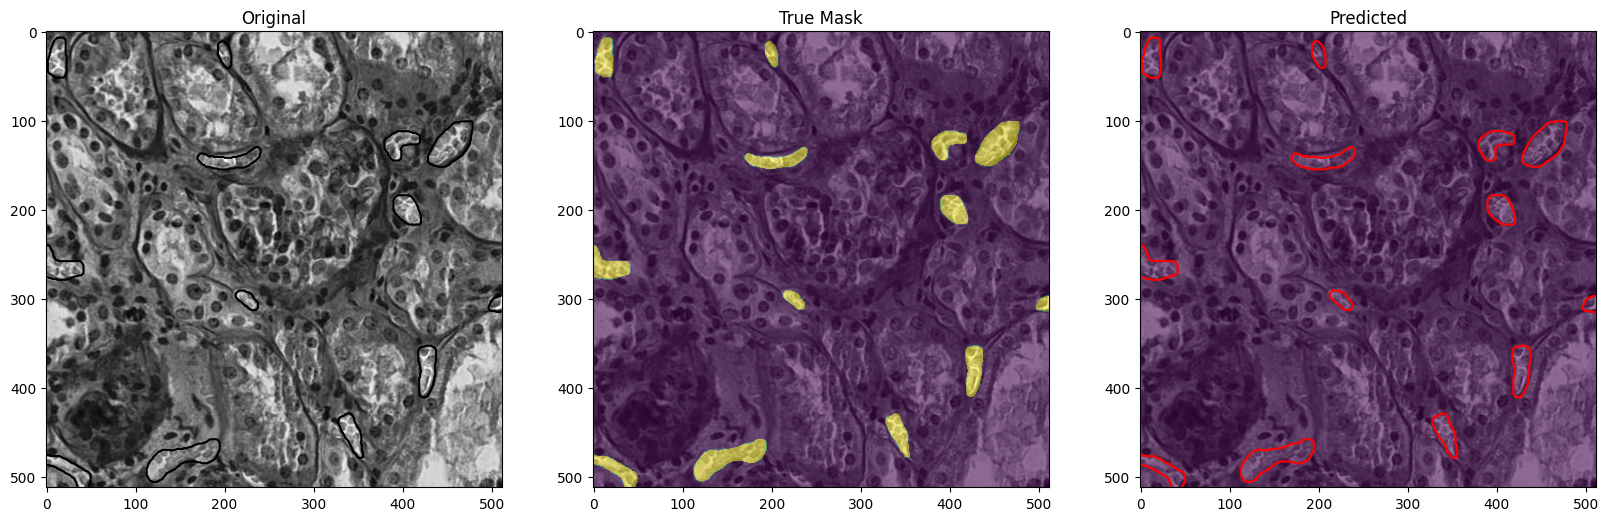

In [78]:
# Visualización de resultados
import matplotlib.pyplot as plt

def plot_sample(X, y, preds, ix=None):
    if ix is None:
        ix = np.random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].imshow(X[ix, ..., 0], cmap='gray', alpha=0.5)
    ax[1].set_title('True Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
        ax[2].imshow(X[ix, ..., 0], cmap='gray', alpha=0.5)

    ax[2].set_title('Predicted')

# Predicciones

plot_sample(X, y, preds_val)